### Import required libraries

In [14]:

import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances
from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import RadViz
from yellowbrick.features import Rank2D
from sklearn.linear_model import Lasso
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix

from imblearn.over_sampling import SMOTE 
from collections import Counter

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve
import pickle

%matplotlib inline

### Increase the size of the screen

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Decrypt Credentials and Connect to Database

In [3]:
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

#Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the clean dataset

In [4]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM songs_instances_data', con = conn)
print('--- %s seconds ---' % (time.time() - start_time))
    
df.drop(['index'],axis=1, inplace=True)
df.head(15)

df.describe()
#print(df.columns)

--- 1.1526987552642822 seconds ---


duration      loudness          mode         tempo  time_signature  speed_general  artist_familiarity  artist_hotttnesss  words_song_u    words_song  words_song_r  words_genre_u   words_genre  words_genre_r  words_second     gnr_Blues   gnr_Country      gnr_Folk      gnr_Funk  gnr_House Electronic Trance      gnr_Jazz     gnr_Latin     gnr_Metal       gnr_Pop  gnr_Pop Standards      gnr_Punk  gnr_Rap Hip Hop  gnr_Rhythm and Blues      gnr_Rock  gnr_Rock and Roll  gnr_Ska Reggae Dancehall         key_0         key_1         key_2         key_4         key_5         key_6         key_7         key_8         key_9        key_10        key_11      is_top40
count  12186.000000  12186.000000  12186.000000  12186.000000    12186.000000   12186.000000        12186.000000       12186.000000  12186.000000  12186.000000  12186.000000   12186.000000  12186.000000   12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000                 12186.000000  12186.000000  12186.000000  12186.000000  12186.000000       12186.000000  12186.000000     12186.000000          12186.000000  12186.000000       12186.000000              12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000  12186.000000
mean     237.958149     -9.210278      0.710323    124.213282        3.625800       2.496061            0.670705           0.480039     86.928405    258.912200      0.364905      87.401773    259.318808       0.341486      1.415067      0.006729      0.067537      0.025603      0.000328                     0.029706      0.022403      0.006565      0.067372      0.137043           0.019449      0.002298         0.045626              0.049401      0.370015           0.031019                  0.002872      0.122025      0.081077      0.110947      0.087313      0.077056      0.057935      0.117348      0.056048      0.109798      0.068603      0.080913      0.378467
std       90.164427      3.902536      0.453631     31.426268        1.115109       0.561251            0.124419           0.116476     34.159980    124.566154      0.112226      21.483921     73.509243       0.035251      0.375368      0.081758      0.250959      0.157955      0.018115                     0.169783      0.147996      0.080761      0.250676      0.343906           0.138101      0.047881         0.208681              0.216713      0.482828           0.173377                  0.053518      0.327328      0.272964      0.314079      0.282305      0.266691      0.233631      0.321847      0.230024      0.312651      0.252789      0.272712      0.485025
min        2.000000    -37.695999      0.000000      0.000000        0.000000       1.000000            0.000000           0.000000      1.000000      1.000000      0.040000      67.000000    172.000000       0.260000      0.302600      0.000000      0.000000      0.000000      0.000000                     0.000000      0.000000      0.000000      0.000000      0.000000           0.000000      0.000000         0.000000              0.000000      0.000000           0.000000                  0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
25%      182.000000    -11.643750      0.000000    100.853998        4.000000       2.000000            0.589260           0.401092     69.000000    185.000000      0.300000      80.000000    229.000000       0.310000      1.398200      0.000000      0.000000      0.000000      0.000000                     0.000000      0.000000      0.000000      0.000000      0.000000           0.000000      0.000000         0.000000              0.000000      0.000000           0.000000                  0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.

### Visualize only important features (not related with the rankings)

In [5]:

songs = df [['duration', 'loudness', 'mode', 'tempo', 'time_signature', 'speed_general', \
                  'artist_familiarity', 'artist_hotttnesss', 'words_song_u', 'words_song', 'words_song_r', \
                  'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 'gnr_Blues', 'gnr_Country', \
                  'gnr_Folk', 'gnr_Funk', 'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', \
                  'gnr_Pop', 'gnr_Pop Standards', 'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', \
                  'gnr_Rock and Roll', 'gnr_Ska Reggae Dancehall','key_0', 'key_1', 'key_2', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', \
                  'key_9', 'key_10', 'key_11', 'is_top40']]
songs.shape

(12186, 43)

### Correlation Matrix Plot

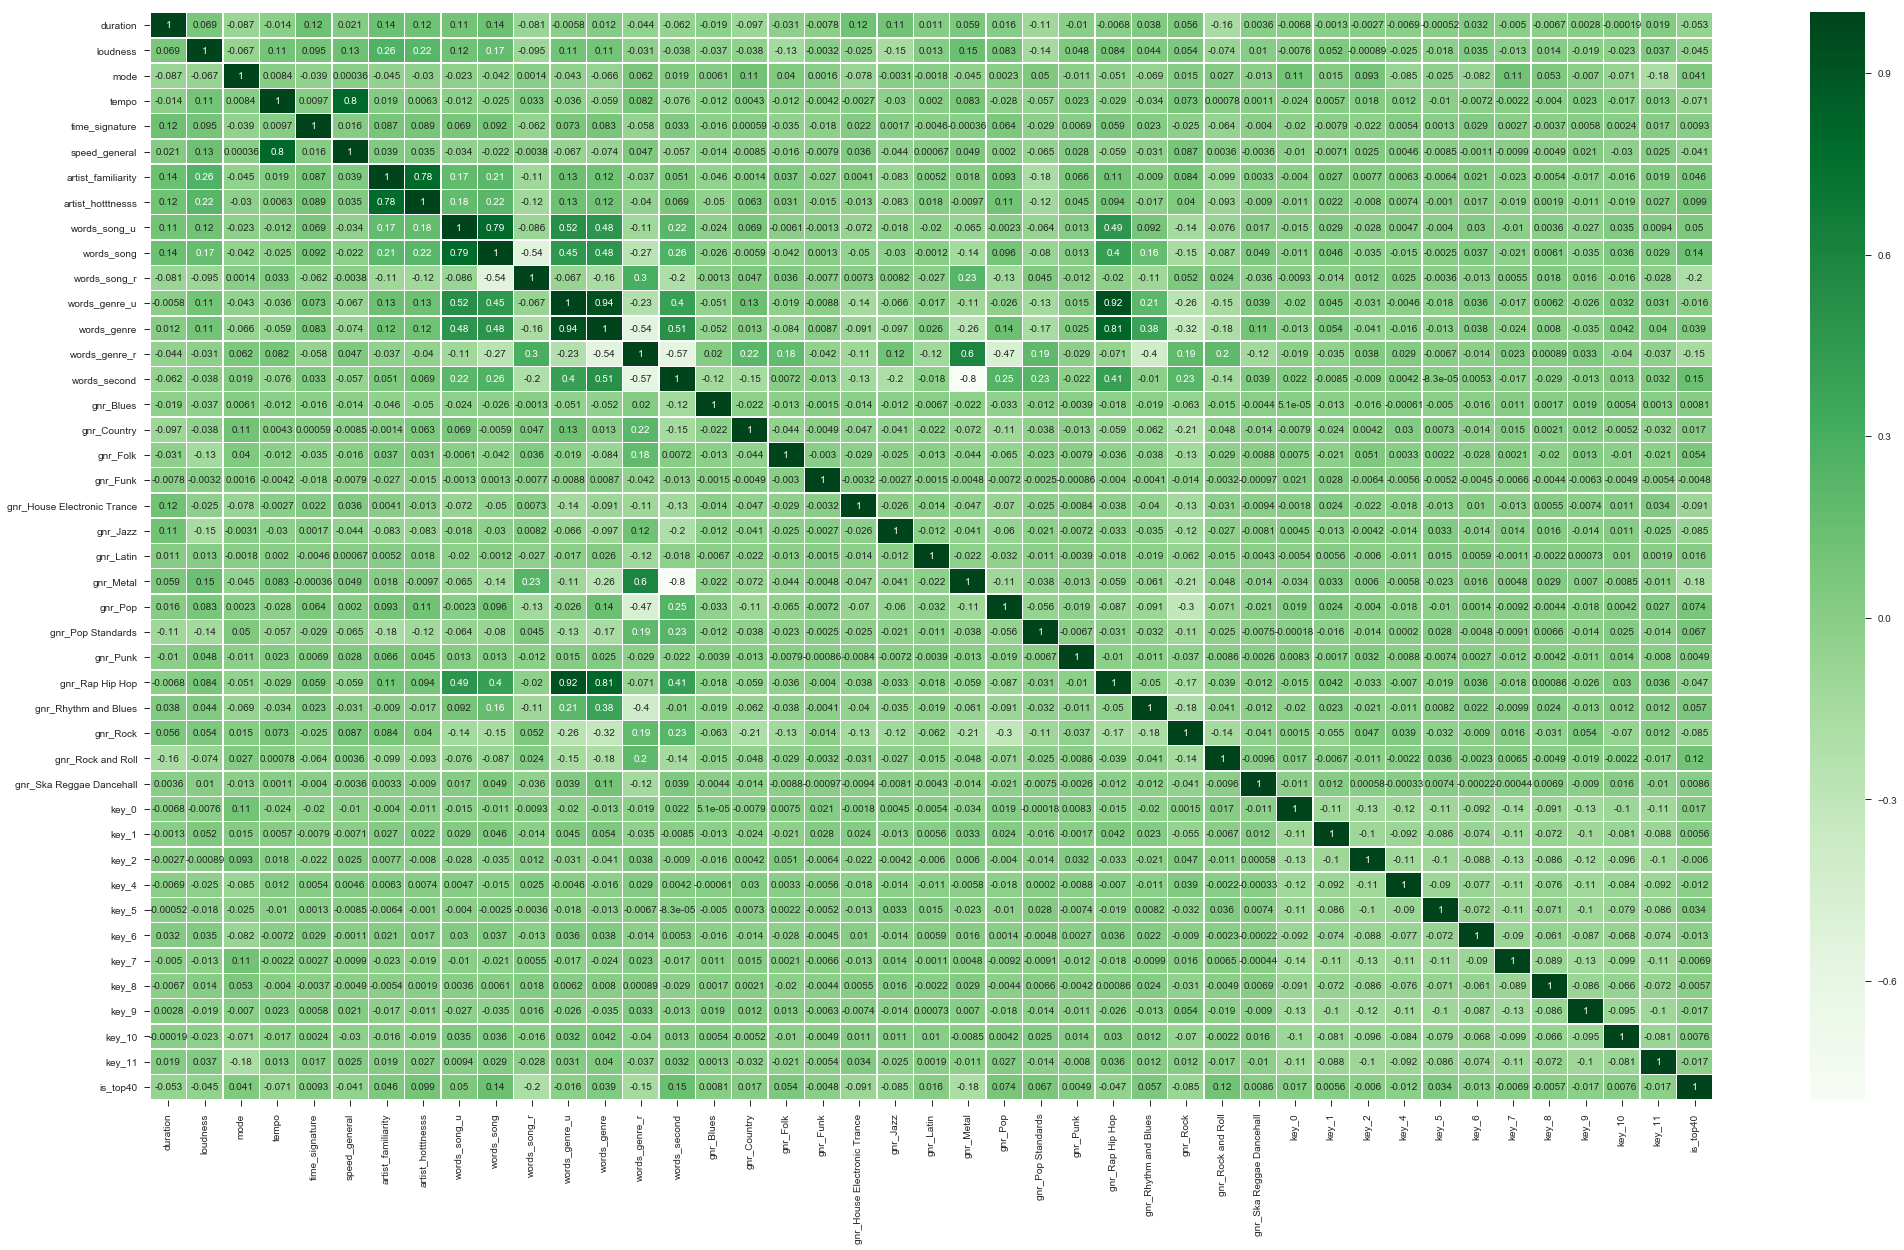

In [131]:
corr = songs.corr()
fig, ax = plt.subplots(figsize=(35,20)) 
ax=sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, linewidths=.5, cmap="Greens")
plt.show()

### Scatterplot

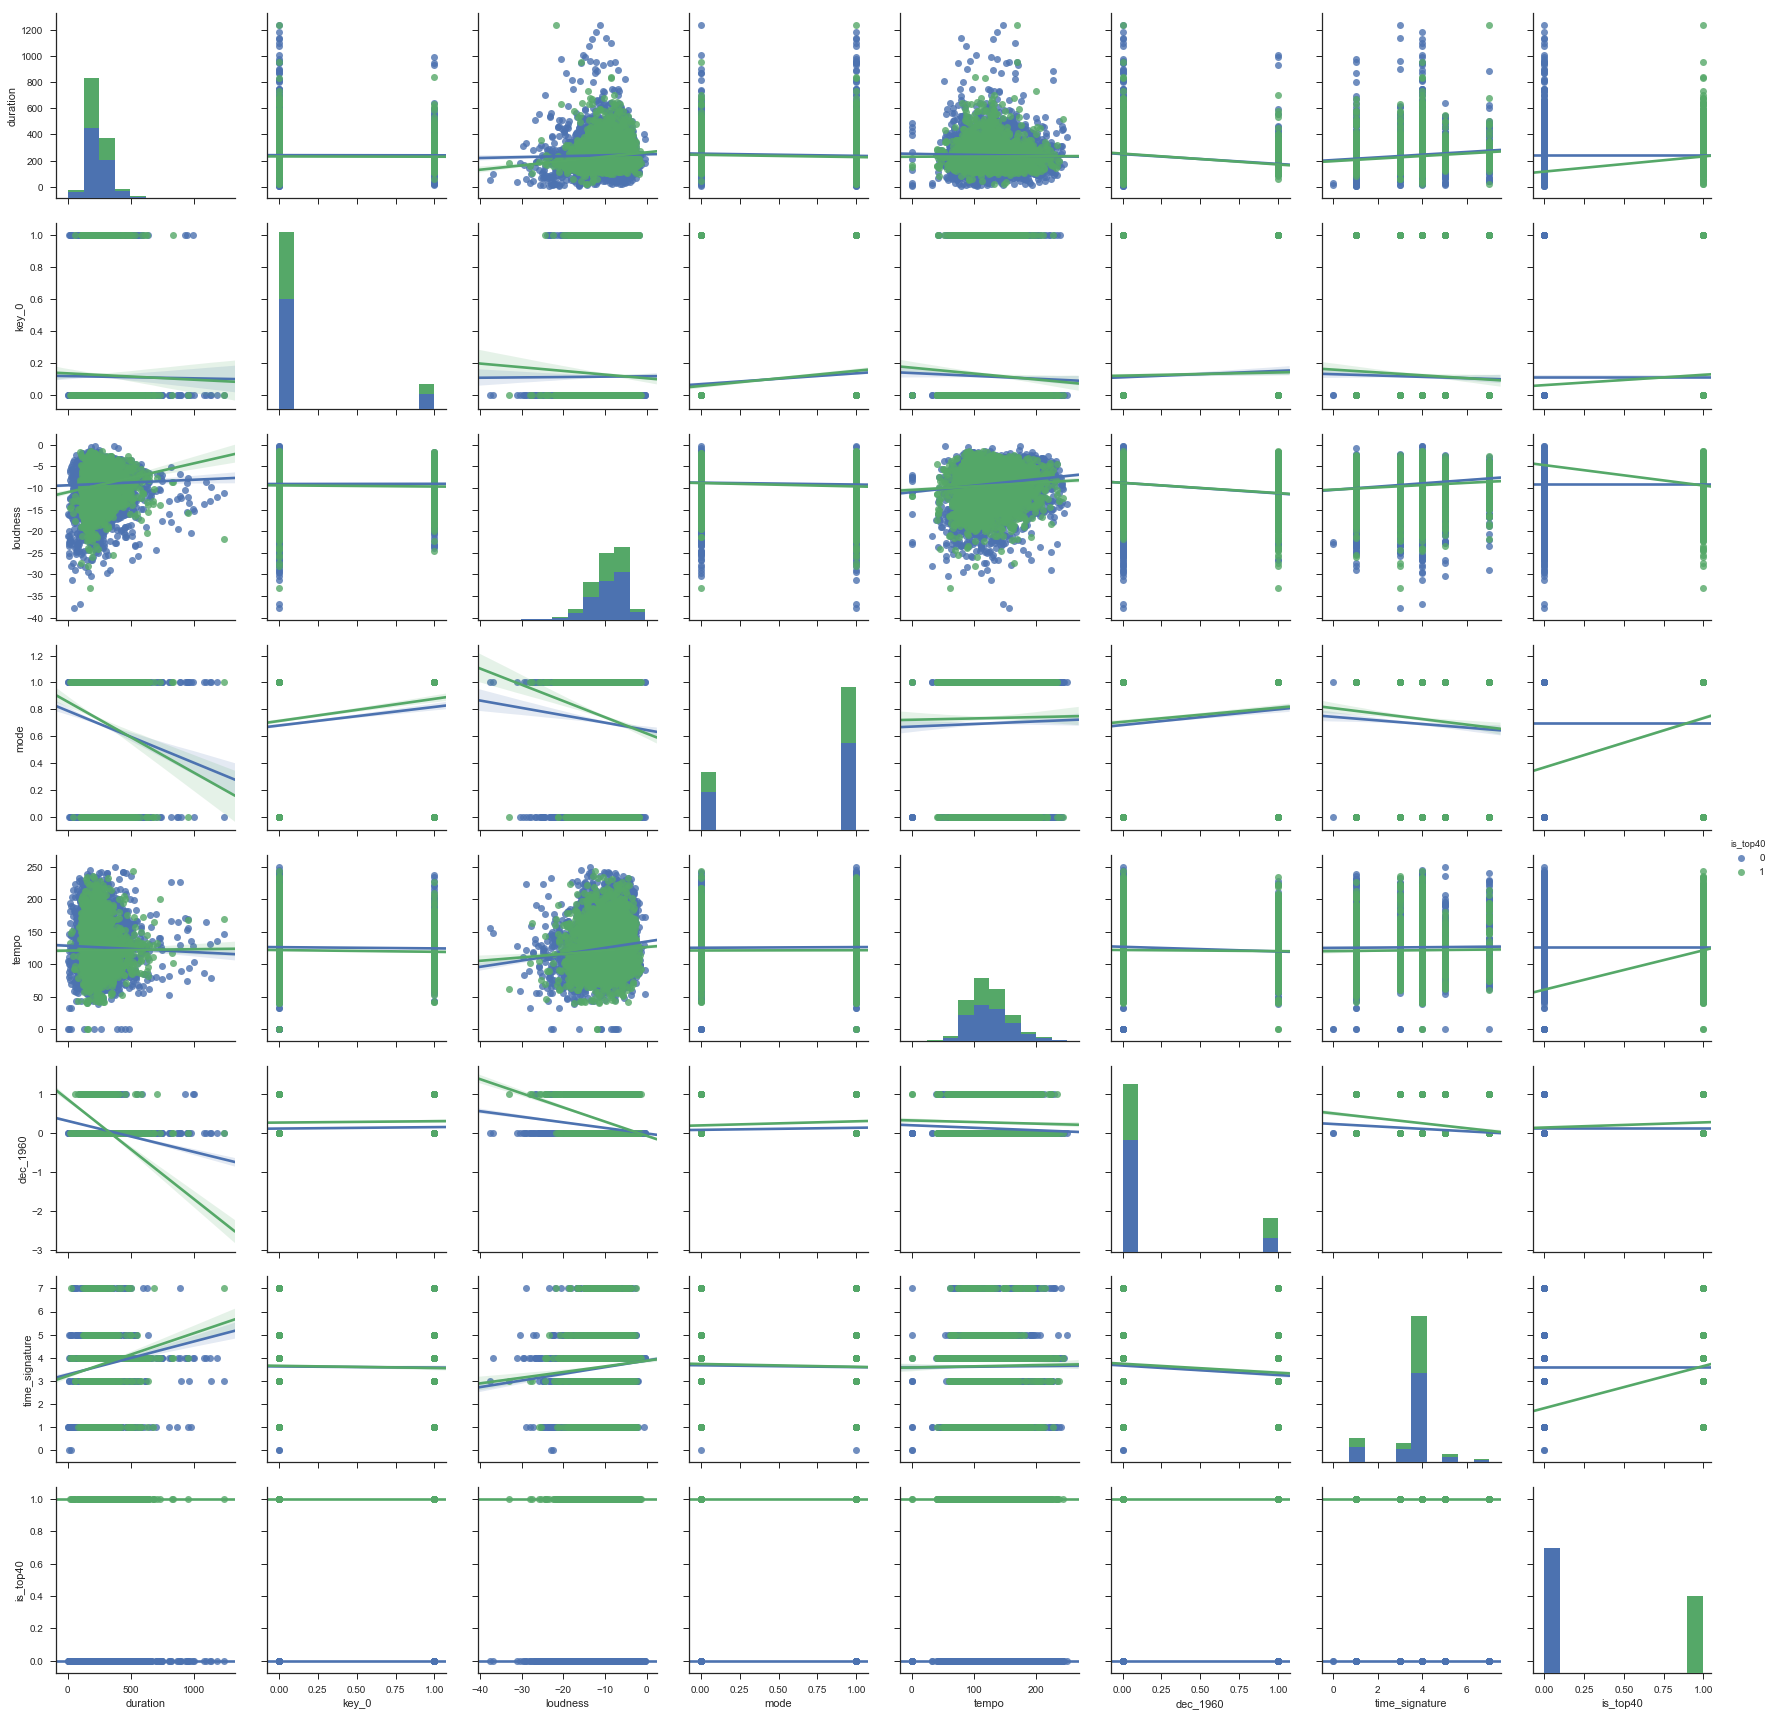

In [80]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['duration', 'key_0', 'loudness', 'mode', 'tempo', 'dec_1960',\
                                      'time_signature','is_top40'], kind="reg")

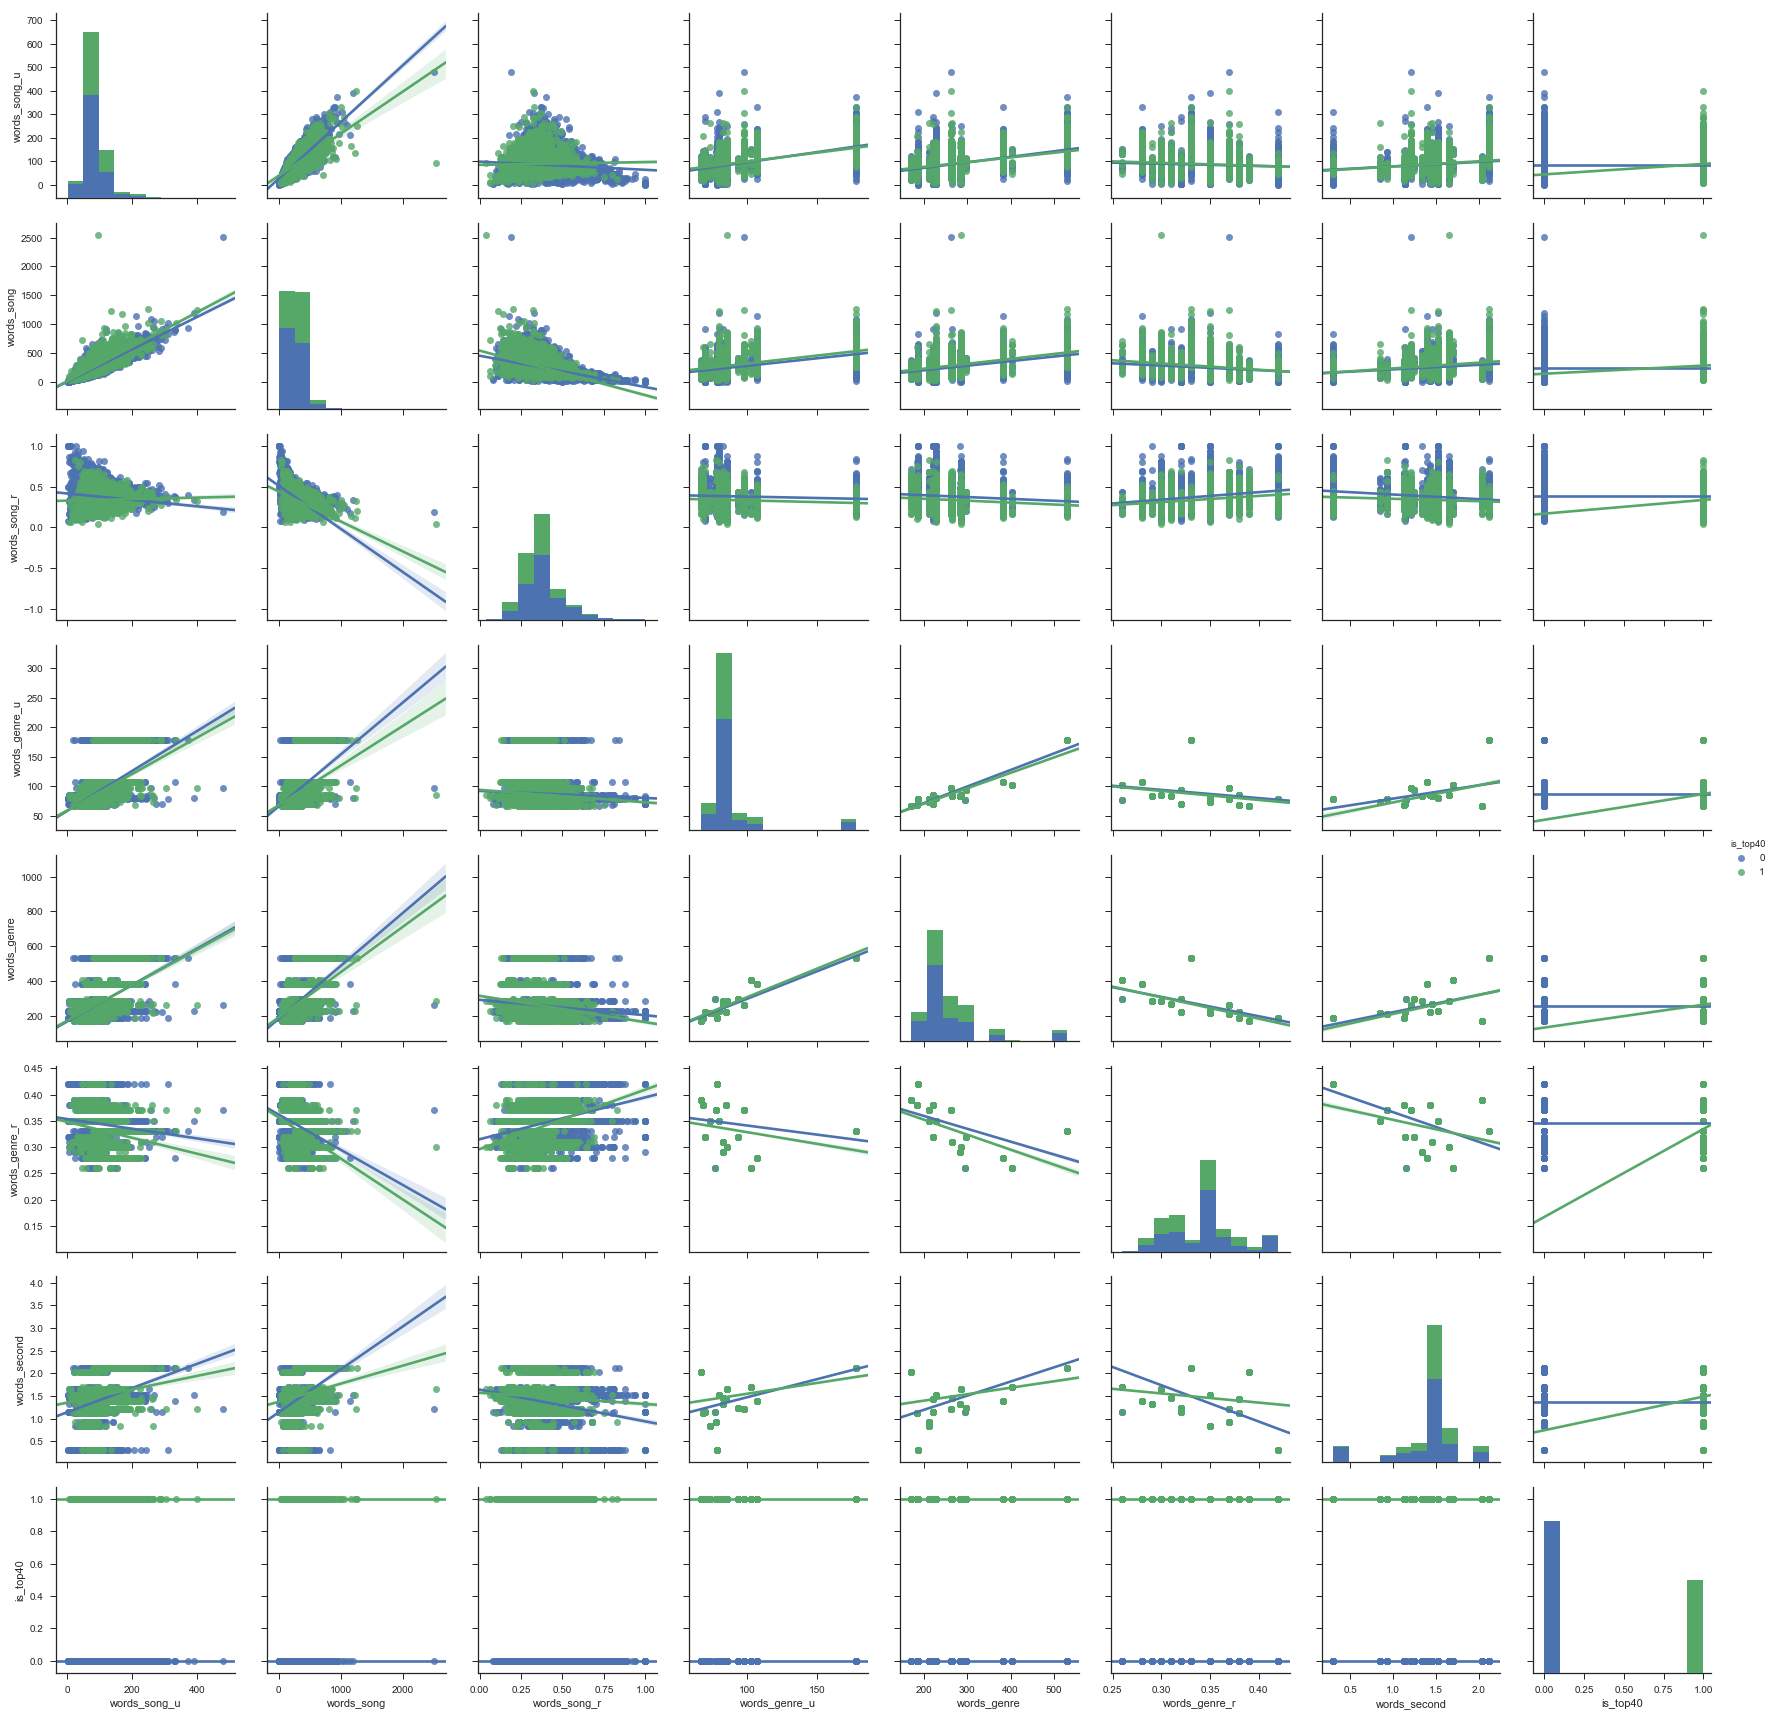

In [79]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['words_song_u','words_song', 'words_song_r', 'words_genre_u','words_genre',\
                                      'words_genre_r','words_second','is_top40'], kind="reg")

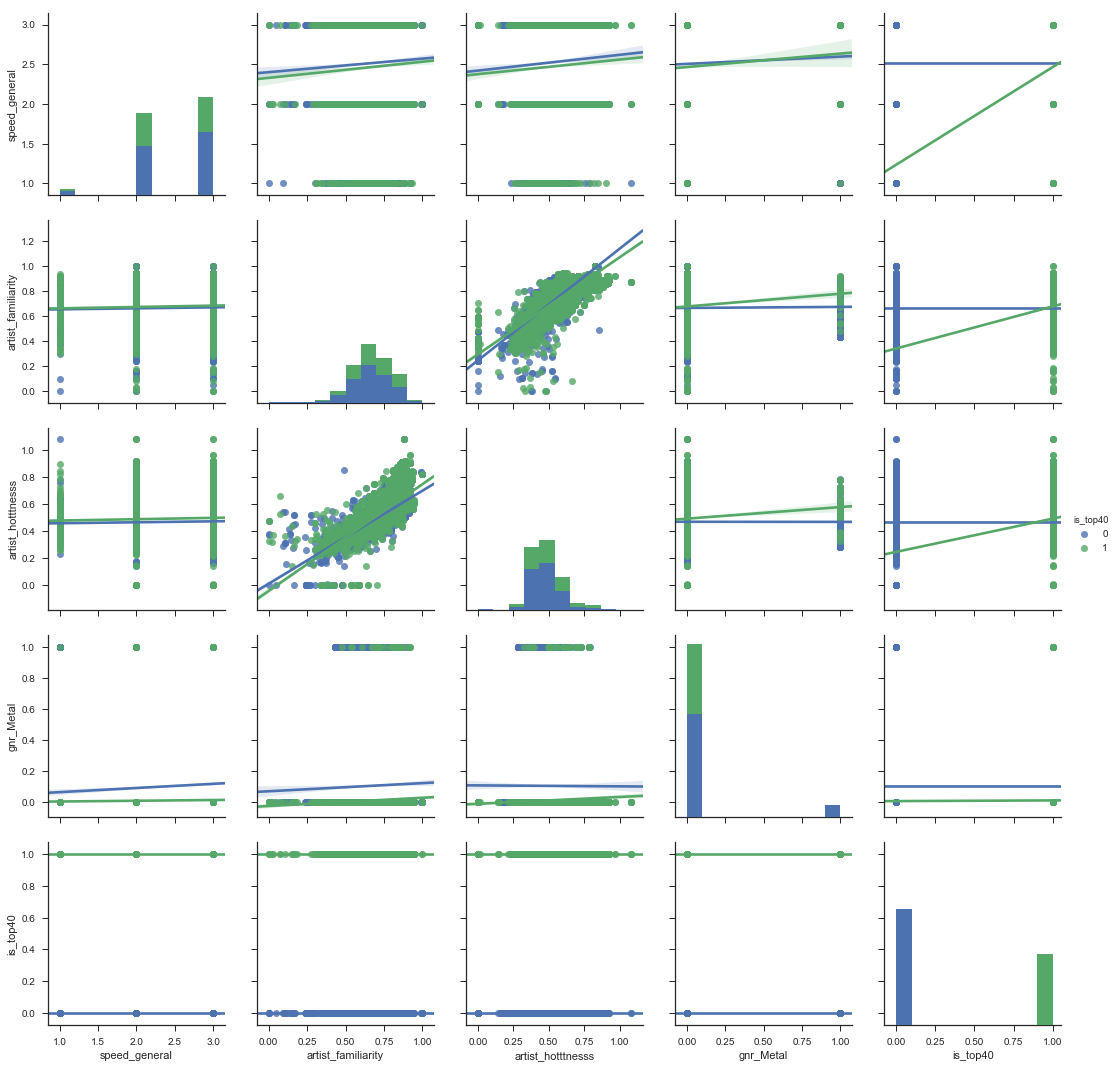

In [80]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(songs,hue='is_top40', size=3, vars=['speed_general', 'artist_familiarity', 'artist_hotttnesss', \
            'gnr_Metal','is_top40'], kind="reg")

### Kernel Density Estimation Plots

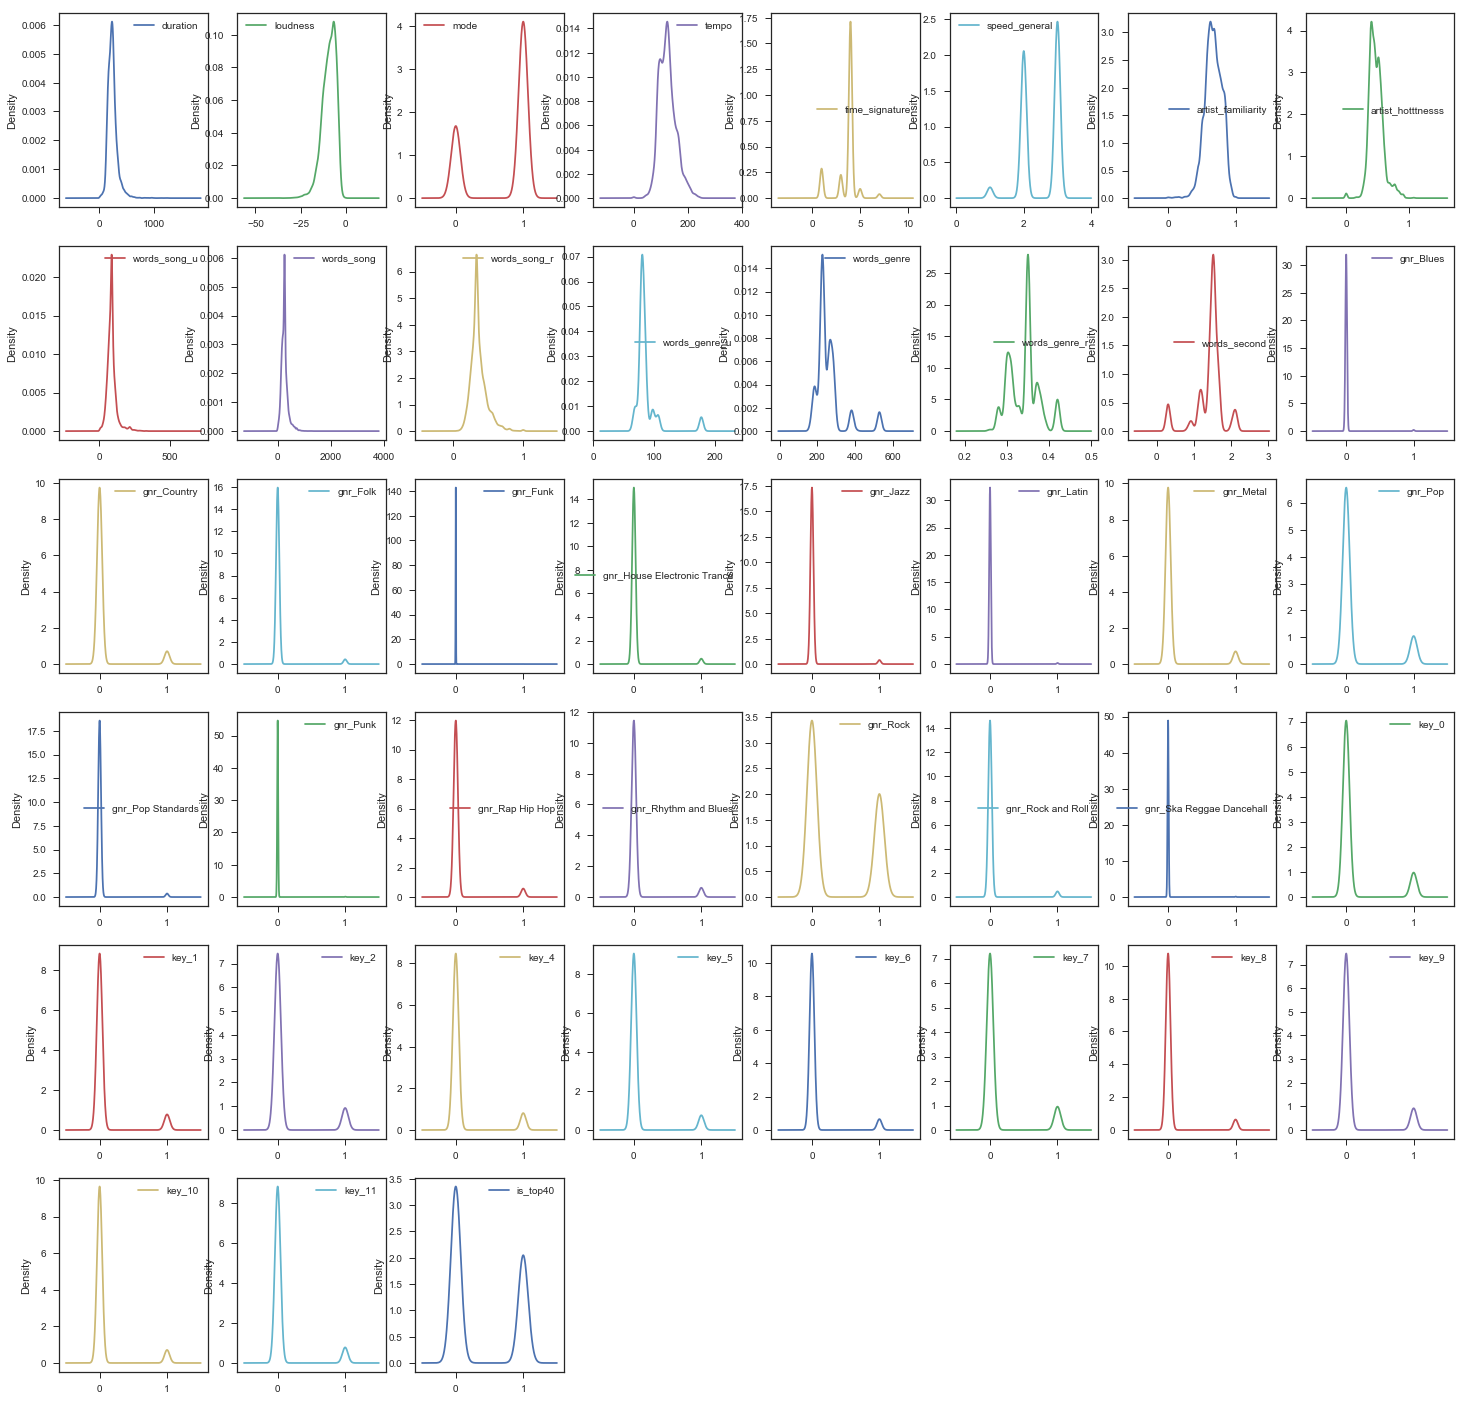

In [133]:
songs.plot(kind='kde', subplots=True, layout=(6,8), sharex=False, sharey=False, figsize=(25,25))
plt.show()

### Box Plots 

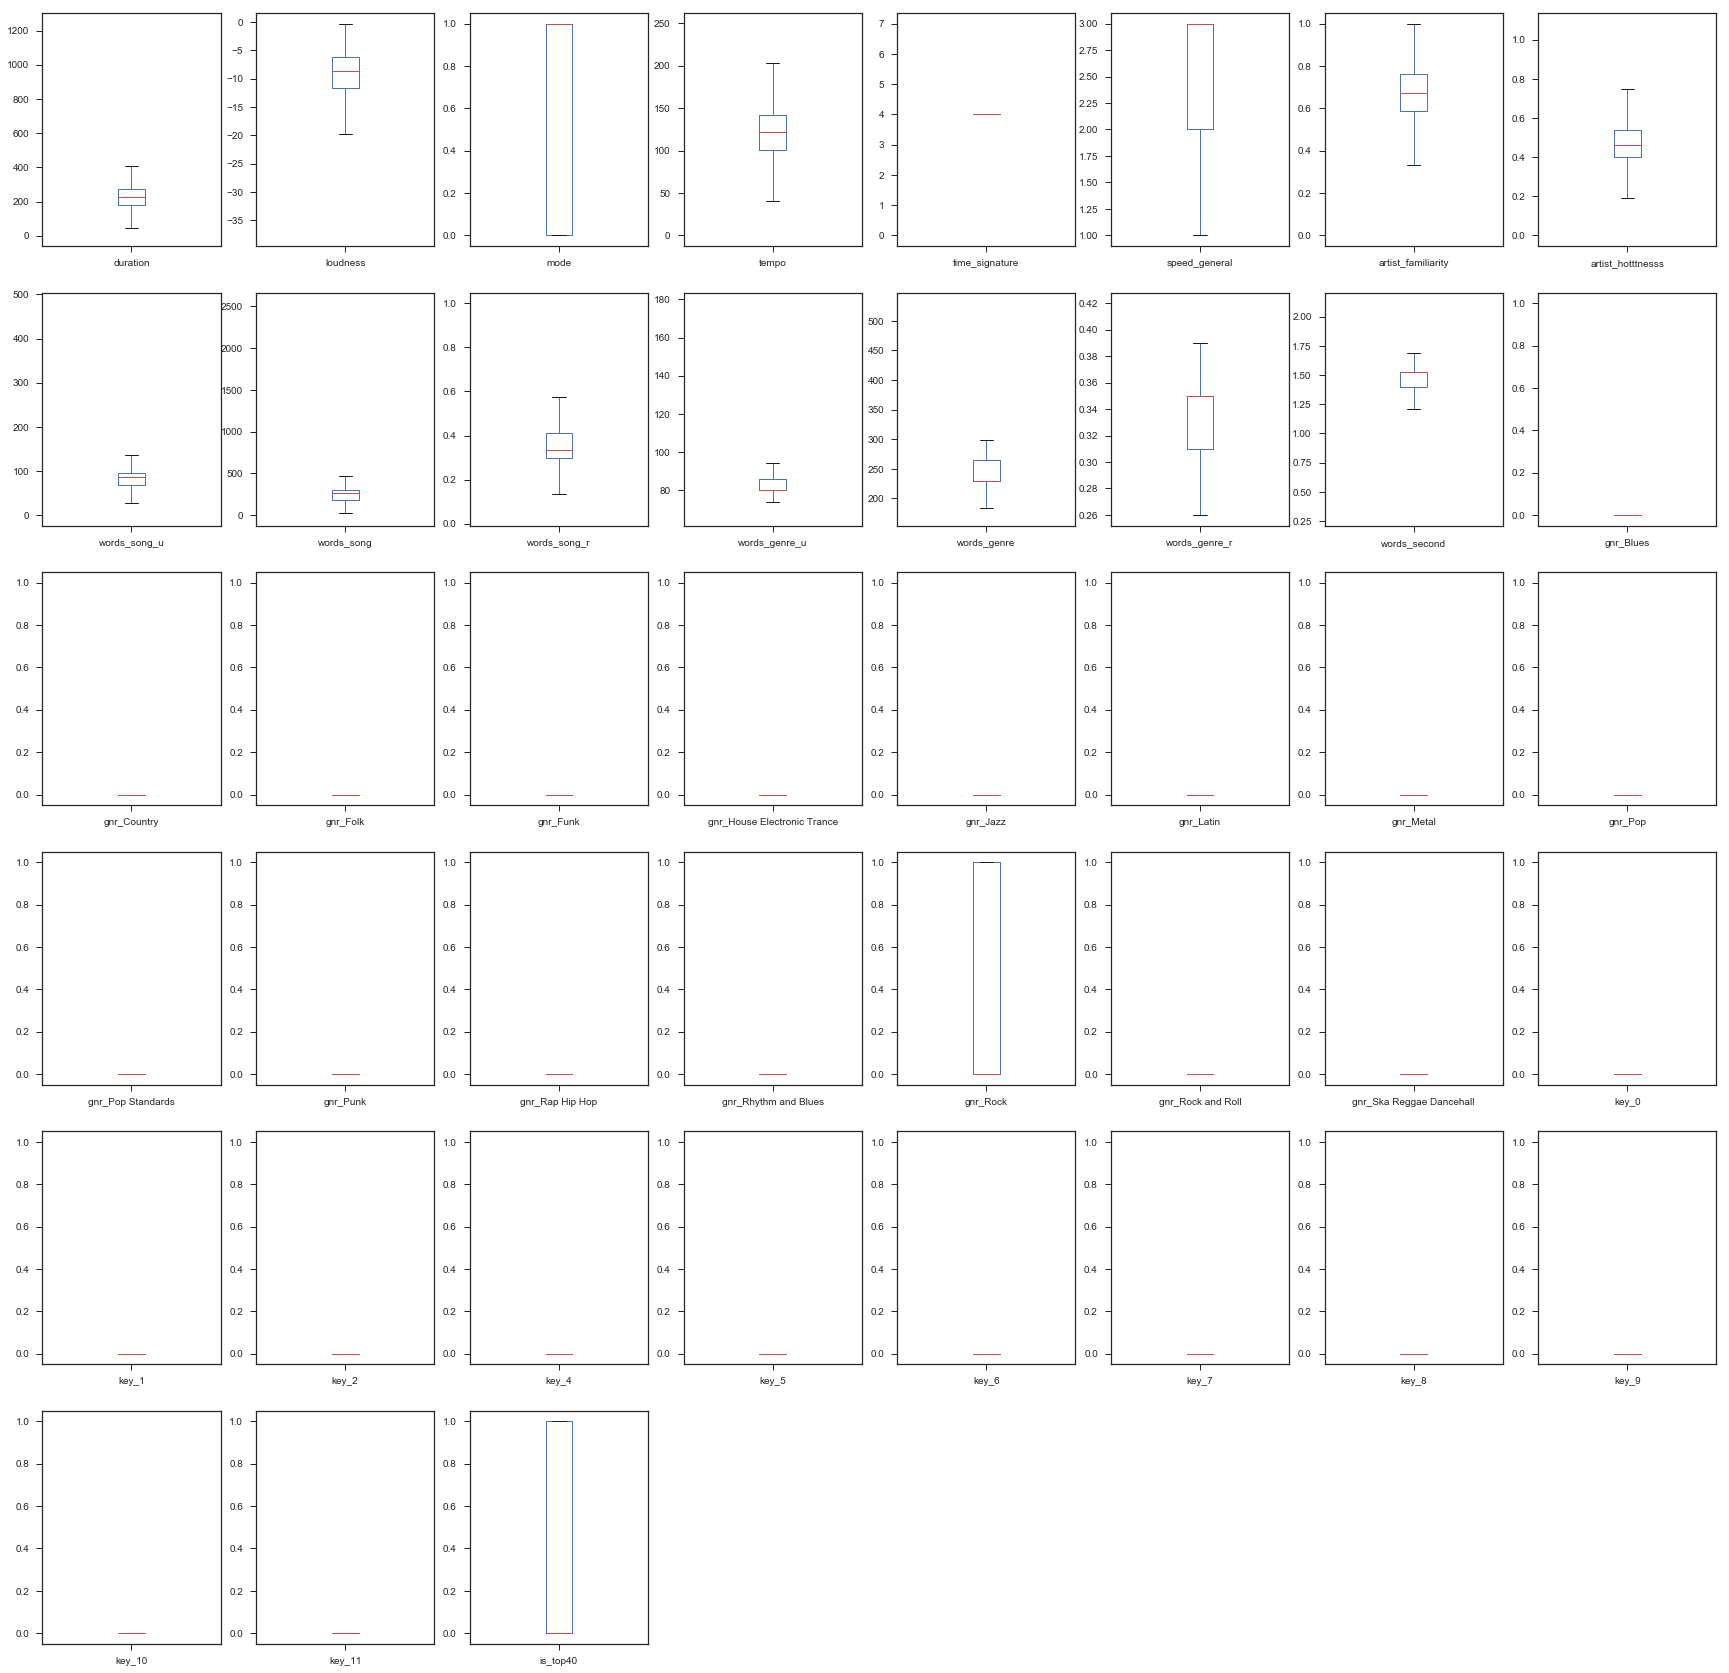

In [134]:
songs.plot(kind='box', subplots=True, layout=(6,8), sharex=False, sharey=False, figsize=(30,30))
plt.show()

### Parallel Coordinates

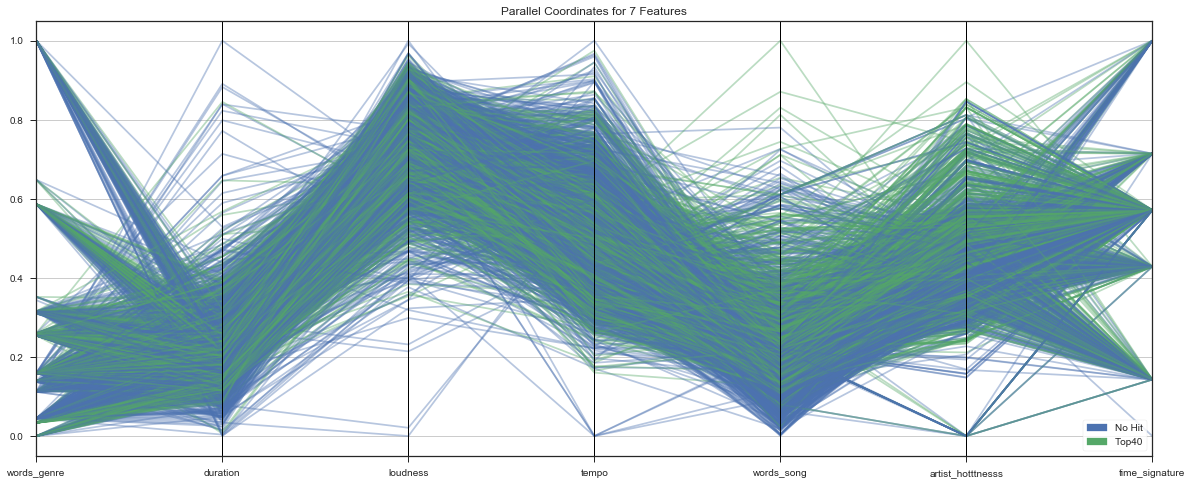

In [181]:
classes = ["No Hit","Top40"]

features = [ 'words_genre','duration', 'loudness', 'tempo' ,'words_song',\
            'artist_hotttnesss', 'time_signature']
X = songs[features]
y = songs.is_top40
_, ax = plt.subplots(figsize=(20,8))
# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features, normalize='minmax',sample=0.3, shuffle=True, alpha = 0.4
)

# Fit and transform the data to the visualizer
visualizer.fit_transform(X, y)

# Finalize the title and axes then display the visualization
visualizer.poof()

### Rad Viz

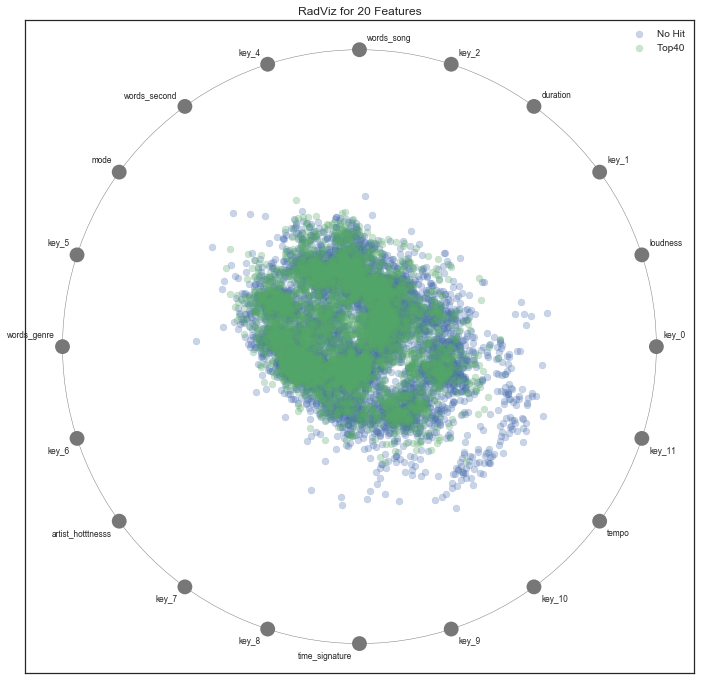

In [186]:
# Specify the features of interest and the classes of the target
classes = ["No Hit", "Top40"]

features = ['key_0', 'loudness','key_1','duration',
'key_2','words_song',
'key_4','words_second',
'mode','key_5','words_genre',
'key_6',
'artist_hotttnesss','key_7',
'key_8',
'time_signature','key_9',
'key_10',
'tempo',
'key_11']



# Extract the numpy arrays from the data frame
X = songs[features].as_matrix()
Y = songs.is_top40.as_matrix()


# Instantiate the visualizer
_,ax = plt.subplots(figsize=(12,12))
visualizer = RadViz(classes=classes, features=features, alpha=0.3)

visualizer.fit(X, Y)      # Fit the data to the visualizer
visualizer.transform(X)   # Transform the data
visualizer.poof()         # Draw/show/poof the data

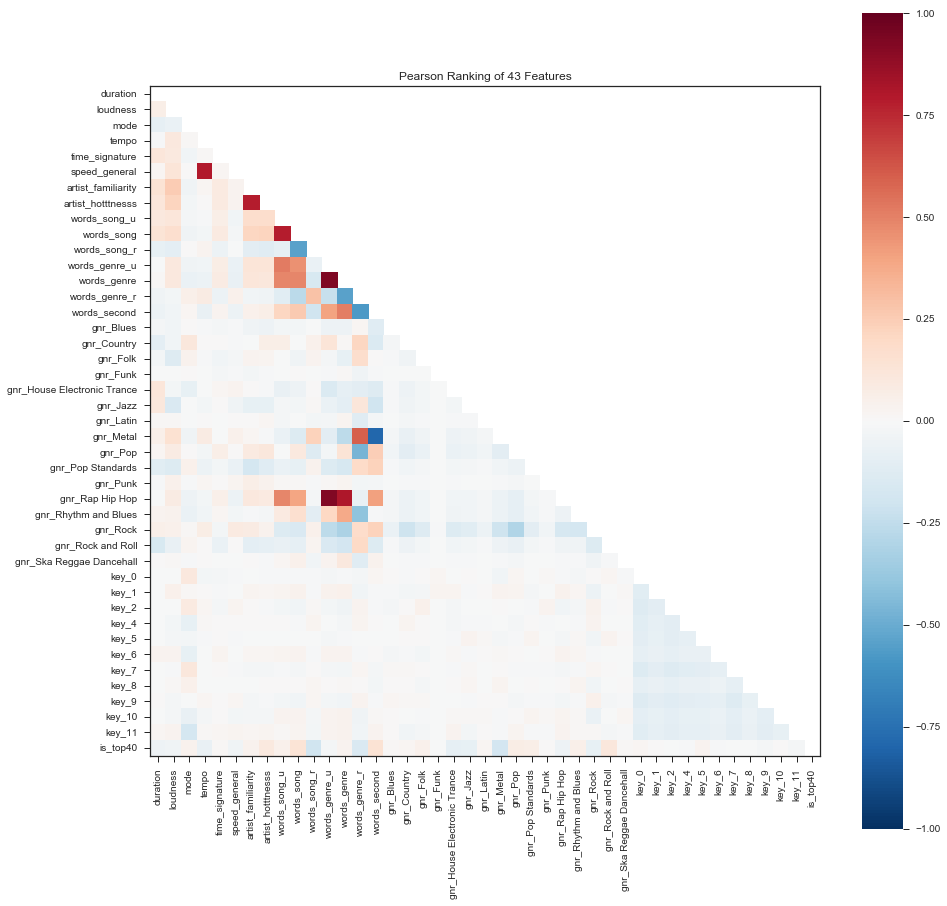

In [141]:
features = ['duration','loudness', 'mode', 'tempo', 'time_signature', 'speed_general', \
                  'artist_familiarity', 'artist_hotttnesss', 'words_song_u', 'words_song', 'words_song_r', \
                  'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 'gnr_Blues', 'gnr_Country', \
                  'gnr_Folk', 'gnr_Funk', 'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', \
                  'gnr_Pop', 'gnr_Pop Standards', 'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', \
                  'gnr_Rock and Roll', 'gnr_Ska Reggae Dancehall','key_0','key_1','key_2','key_4','key_5','key_6',\
                  'key_7','key_8','key_9','key_10','key_11','is_top40']
X = songs[features].as_matrix()
y = songs.is_top40.as_matrix()
# Instantiate the visualizer with the Covariance ranking algorithm
_,ax = plt.subplots(figsize=(15,15))
visualizer = Rank2D(features=features, algorithm='pearson')

visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof()                   # Draw/show/poof the data

### Avoiding Collinearity between features, reducing features and therefore complexity in the model

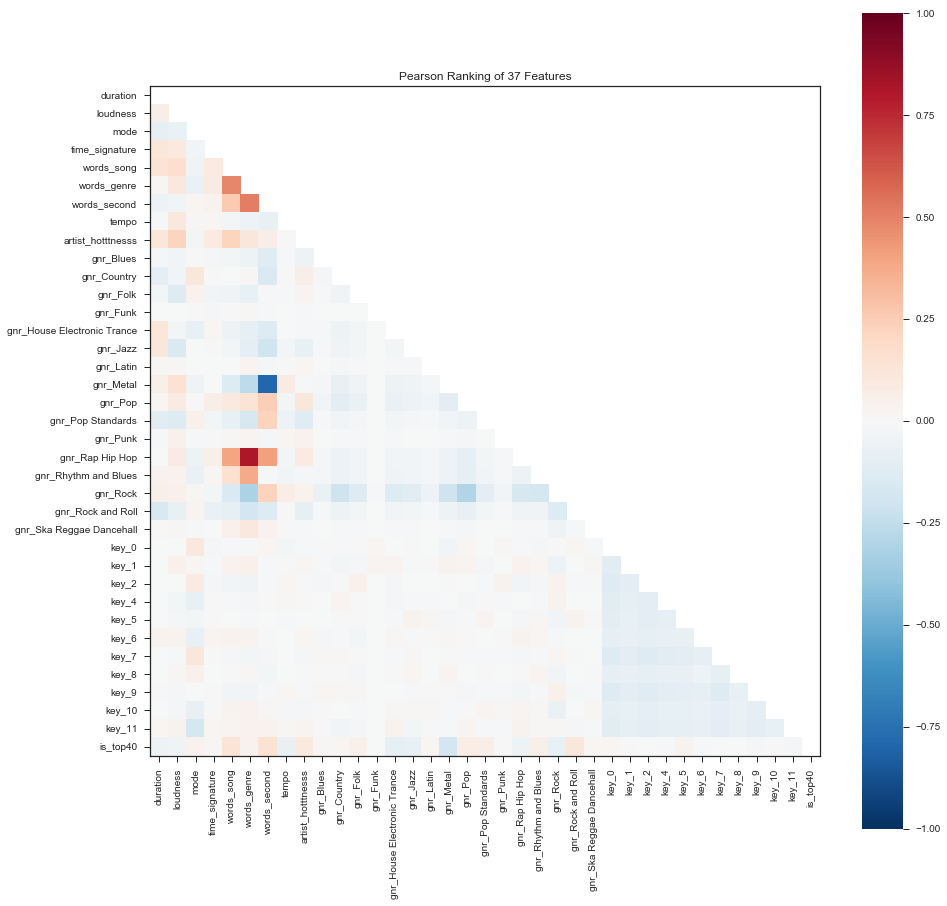

In [143]:
less_features = ['duration', 'loudness', 'mode','time_signature', \
             'words_song','words_genre', 'words_second', 'tempo', \
             'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall','key_0','key_1','key_2','key_4','key_5','key_6','key_7','key_8','key_9',
             'key_10','key_11','is_top40']
X1 = songs[less_features].as_matrix()
Y1 = songs.is_top40.as_matrix()
# Instantiate the visualizer with the Covariance ranking algorithm
_,ax = plt.subplots(figsize=(15,15))
visualizer = Rank2D(features=less_features, algorithm='pearson')

visualizer.fit(X1, Y1)                # Fit the data to the visualizer
visualizer.transform(X1)             # Transform the data
visualizer.poof()     

# Initial Model Comparison

### Split-Out validation dataset

In [6]:
songs = df [['duration', 'loudness', 'mode','time_signature', \
             'words_song','words_genre', 'words_second', 'tempo', \
             'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall','key_0','key_1','key_2','key_4','key_5','key_6','key_7','key_8','key_9',
             'key_10','key_11','is_top40']]
array = songs.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40
    
sm = SMOTE(random_state=42)
X_resampled, Y_resampled = sm.fit_sample(X, Y)
X_resampled.shape
    
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X_resampled, Y_resampled,test_size=validation_size,random_state=seed)
print(songs.shape)
print(X_train.shape)
print(X_validation.shape)

(12186, 37)
(12118, 36)
(3030, 36)


  ### Test options and evaluation metric

In [7]:
seed = 7
scoring = 'accuracy'

### Selected Algorithms

In [149]:
# models = []
# #Naive Bayes,
#models.append(('NB', GaussianNB(priors = [0.99,0.01])))
#models.append(('BNB', BernoulliNB(alpha = 0.001, binarize = 0.95, class_prior = [0.8,0.2], fit_prior = True)))
# # #Decision Tree,
# models.append(('CART',DecisionTreeClassifier(criterion = 'entropy', splitter='random',
#                                              max_depth = 10,max_leaf_nodes = 12,
#                                              min_impurity_decrease = 0.35, random_state = 7)))
# models.append(('RFC', RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini',
#                                              max_features = 'auto', max_depth = None,
#                                              max_leaf_nodes =None,n_estimators = 120, warm_start = False, random_state = 7)))

# Discriminant Analysis,
#models.append(('LDA', LinearDiscriminantAnalysis(n_components= 0, solver= 'svd', store_covariance= True, tol= 0.0001)))


# #LogisticRegression,
# {'C': 1.5, 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 0.0001},
# models.append(('LRG', LogisticRegression(C= 1.1, class_weight= 'balanced', dual= False, fit_intercept= True, max_iter= 90, multi_class= 'ovr', n_jobs= 1, penalty= 'l2', random_state= 2, solver= 'liblinear', tol= 0.0001, verbose= 0, warm_start= False)))
#{'Cs': 2, 'cv': 10, 'solver': 'liblinear', 'tol': 0.1},
#models.append(('LCV', LogisticRegressionCV(Cs= 10, class_weight= 'balanced', cv= 5, dual= False, fit_intercept= True, intercept_scaling= 1, max_iter= 120, multi_class= 'ovr', n_jobs= 1, penalty= 'l1', random_state= 2, refit= True, solver= 'liblinear', tol=0.0001, verbose= 2)))

#KNN,
#models.append(('KNN', KNeighborsClassifier(algorithm = 'ball_tree', leaf_size =20,  metric = 'minkowski',n_neighbors=7, 
#                             p = 2, weights='uniform', n_jobs= -1)))
#models.append(('NCT', NearestCentroid()))
#models.append(('KNN', NearestNeighbors()))
#models.append(('RNC', RadiusNeighborsClassifier(radius=5.0, outlier_label=1)))
#Support Vector Machine,
#models.append(('SVM', SVC()))#(kernel='linear', C=0.025))) 
# models.append(('NuSVM', NuSVC()))
# models.append(('LinearSVC', LinearSVC(C=0.75, max_iter=2000))) 
# models.append(('ABC',AdaBoostClassifier()))
#{'activation': 'identity', 'learning_rate': 'constant', 'max_iter': 500, 'random_state': 7, 'shuffle': True, 'solver': 'lbfgs'}
#models.append(('Neural Network',MLPClassifier()))#activation='identity',learning_rate='constant',#max_iter=500,
#                                              random_state=7,shuffle=True,
#                                               solver='lbfgs')))
#LogisticRegressionCV().get_params(deep = True),

# alpha_spc = np.linspace(0.0,0.5,num=10, endpoint=True)
# for a in range(len(alpha_spc)):
# models.append(('CART'+str(alpha_spc[a]),DecisionTreeClassifier(criterion = 'entropy', splitter='random', max_depth =10,max_features= 13,
#max_leaf_nodes = 12, min_impurity_split = 0.35, random_state = 7,
#min_weight_fraction_leaf = int(alpha_spc[a]))))
# print(str(alpha_spc[a]))



# KNeighborsClassifier().get_params(deep = True)
# n_neighbors = np.linspace(1,12,num=12, endpoint=True)
# for a in range(len(n_neighbors)):
#     models.append(('KNC'+ str(int(n_neighbors[a])), KNeighborsClassifier(algorithm = 'auto', metric = 'minkowski', n_jobs= -1, n_neighbors= int(n_neighbors[a]))))
    
# print(models)
                                                                       


# import numpy as np
# from yellowbrick.model_selection import ValidationCurve

# pr = np.linspace(1, 5, num=5, endpoint=True)
# print(np.linspace(1, 5, num=5, endpoint=True))
# model = ValidationCurve(KNeighborsClassifier(), param_name="n_neighbors", param_range=pr)
# model.fit(X_train, Y_train)
# model.poof()


In [8]:
models = []
models.append(('RFC', RandomForestClassifier(criterion= 'gini', max_depth= 20, n_estimators= 120)))
models.append(('LGR', LogisticRegression(C= 1.15, class_weight= 'balanced', dual= False, fit_intercept= True, 
                           max_iter= 10000, multi_class= 'ovr', n_jobs= 2, random_state= 7, solver= 'sag', tol= 0.0001,
                           verbose= 0, warm_start= True)))
models.append(('ABC', AdaBoostClassifier()))

### Initial Evaluation Each Model in Turn

In [166]:
results = []
names = []

# print('\nTest Accuracy with Scaling and PCA\n')
# start_time = time.time()
# for name, model in models:
#     pipe_mdl = make_pipeline(StandardScaler(),
#                         PCA(n_components=18),
#                         model)
#     pipe_mdl.fit(X_train, Y_train)
#     y_pred = pipe_mdl.predict(X_validation)
#     pipe_results =pipe_mdl.score(X_validation, Y_validation)
#     print('%s Test Accuracy: %f' % (name, pipe_results))
# print('--- %s seconds ---' % (time.time() - start_time))    
# print()



#print('\nTest Accuracy with Stratified KFold within Pipeline \n')
# from sklearn.model_selection import StratifiedKFold
# for name, model in models:
#     pipe_mdl = make_pipeline(StandardScaler(),
#                         PCA(n_components=18),
#                         model)
#     kfold = model_selection.StratifiedKFold(n_splits=10, random_state=1).split(X_train,Y_train)
#     scores = []
#     mnames = []
#     for k, (train,test) in enumerate(kfold):
#         pipe_mdl.fit(X_train[train],Y_train[train])
#         score = pipe_mdl.score(X_train[test],Y_train[test])
#         #print('Fold: %2d,  Acc: %.3f' % (k+1,score))
#         scores.append(score)
#         mnames.append(name)
#     print('%s CV accuracy: %.3f +/- %.3f' %(name, np.mean(scores), np.std(scores)))

from sklearn.model_selection import cross_val_score
res_scores = []
m_names = []
for name, model in models:
    start_time = time.time()
    print(name)
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        model)
    kfold = model_selection.KFold(n_splits=12, random_state=7)
    scores = model_selection.cross_val_score(estimator=pipe_mdl,
                         X=X_train,
                         y=Y_train,
                         cv=kfold,
                         #n_jobs=-1,
                         scoring = scoring)
    print('CV accuracy: %.5f +/- %.5f' % (np.mean(scores),np.std(scores)))
    res_scores.append(scores)
    m_names.append(name)
    print('--- %s seconds ---' % (time.time() - start_time))


# print('\nTest Accuracy with KFold Test \n')
# start_time = time.time()
# for name, model in models:    
#     kfold = model_selection.KFold(n_splits=10, random_state=1)
#     cv_results = model_selection.cross_val_score(model, X_validation, Y_validation, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = '%s: %.3f +/- (%.3f)'% (name, cv_results.mean(), cv_results.std())
#     print(msg)
# print('--- %s seconds ---' % (time.time() - start_time))

RFC
CV accuracy: 0.75012 +/- 0.01299
--- 21.058166980743408 seconds ---
LGR
CV accuracy: 0.71136 +/- 0.01410
--- 3.6713457107543945 seconds ---
ABC
CV accuracy: 0.70757 +/- 0.01280
--- 7.2177839279174805 seconds ---


### Compare Algorithms

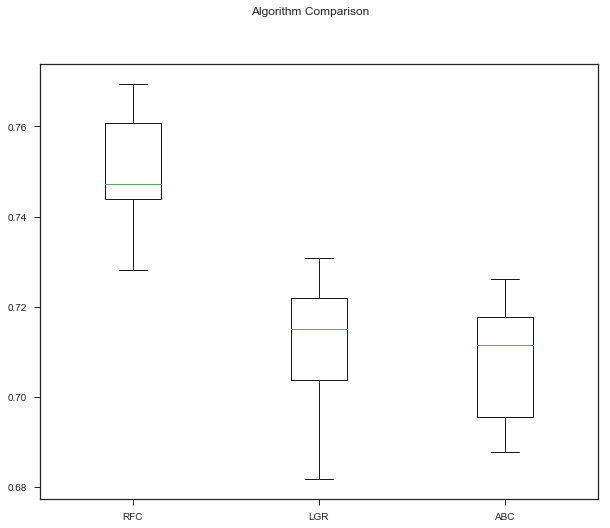

In [167]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res_scores)
ax.set_xticklabels(m_names)
plt.show()

### Applying the Visualization to the Models

RFC
0.7496714848883048
[[1100  386]
 [ 376 1182]]


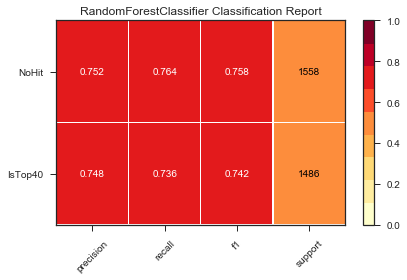

LGR
0.6281208935611038
[[919 567]
 [565 993]]


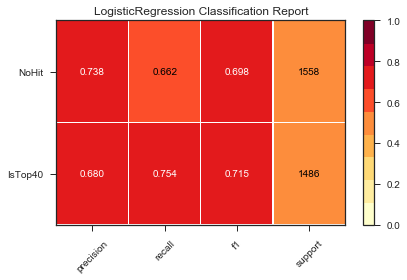

ABC
0.7161629434954008
[[1070  416]
 [ 448 1110]]


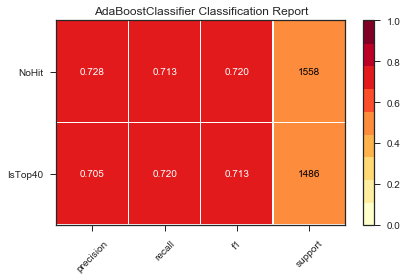

In [187]:
classes = ["IsTop40", "NoHit"]


def plotting(name, model):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print(name)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        model)
    visualizer = ClassificationReport(pipe_mdl, classes=classes, support=True)
    visualizer.fit(X_train, Y_train)  # Fit the visualizer and the model
    visualizer.score(X_validation, Y_validation)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data
    
for name, model in models:
    plotting(name, model)

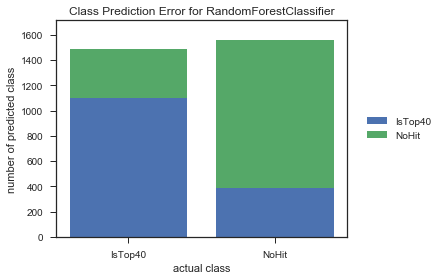

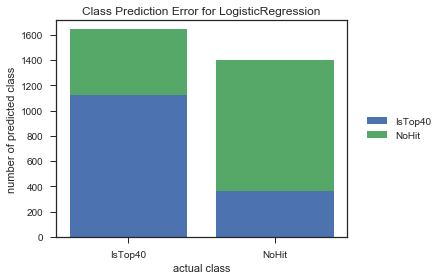

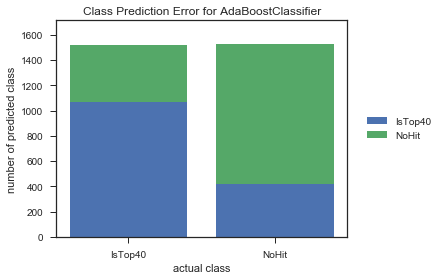

In [188]:
def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        model)
    visualizer = ClassPredictionError(
        pipe_mdl, classes=classes)
    # Fit
    visualizer.fit(X_train, Y_train)
    # Score and visualize
    visualizer.score(X_validation, Y_validation)
    visualizer.poof()
    
for name, model in models:
    vizerror(name, model)

### ROC AUC Curve

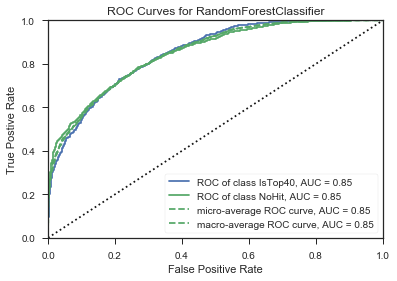

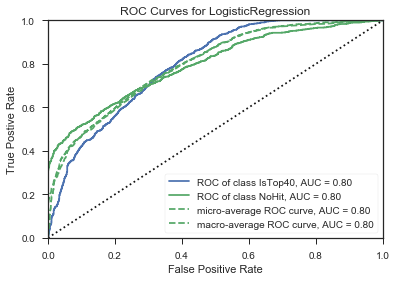

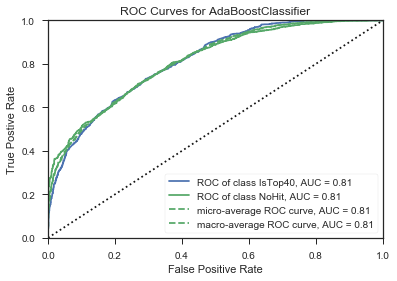

In [189]:
def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        model)
    visualizer = ROCAUC(pipe_mdl, classes=classes)
    # Fit
    visualizer.fit(X_train, Y_train)
    # Score and visualize
    visualizer.score(X_validation, Y_validation)
    visualizer.poof()
    
for name, model in models:
    vizerror(name, model)

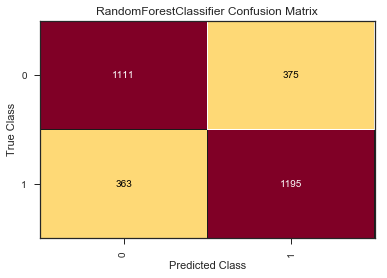

--- 2.04593825340271 seconds ---


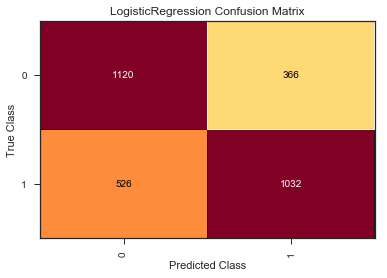

--- 0.40860509872436523 seconds ---


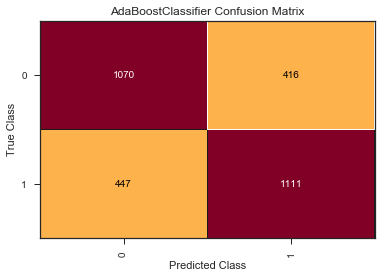

--- 0.7731208801269531 seconds ---


In [190]:
def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        model)
    # The ConfusionMatrix visualizer taxes a model
    cm = ConfusionMatrix(pipe_mdl, classes = [0,1])

    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(X_train, Y_train)

    # To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
    # and then creates the confusion_matrix from scikit-learn.
    cm.score(X_validation, Y_validation)

    # How did we do?
    cm.poof()
    
    
for name, model in models:
    start_time = time.time()
    vizerror(name, model)
    print('--- %s seconds ---' % (time.time() - start_time))

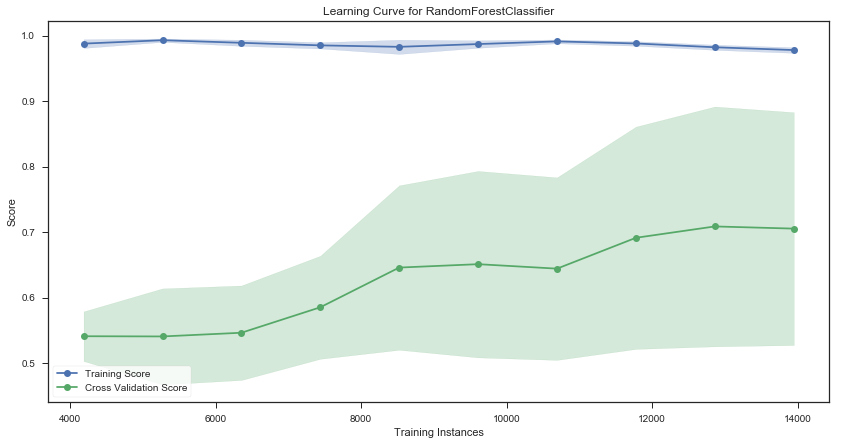

--- 185.75526189804077 seconds ---


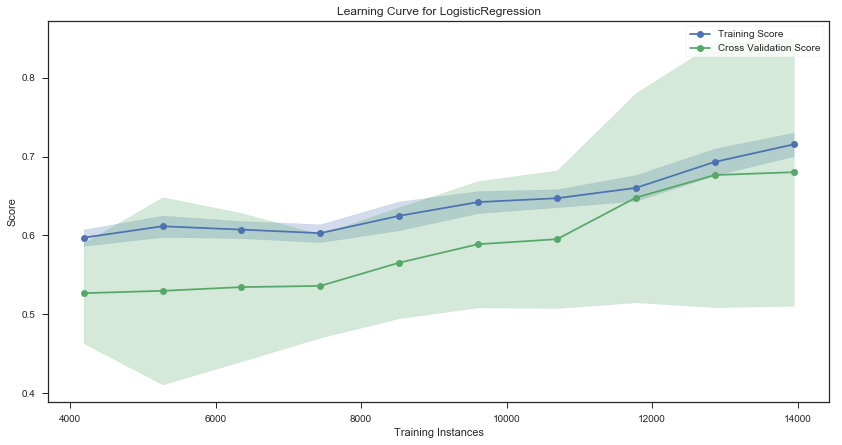

--- 36.54483509063721 seconds ---


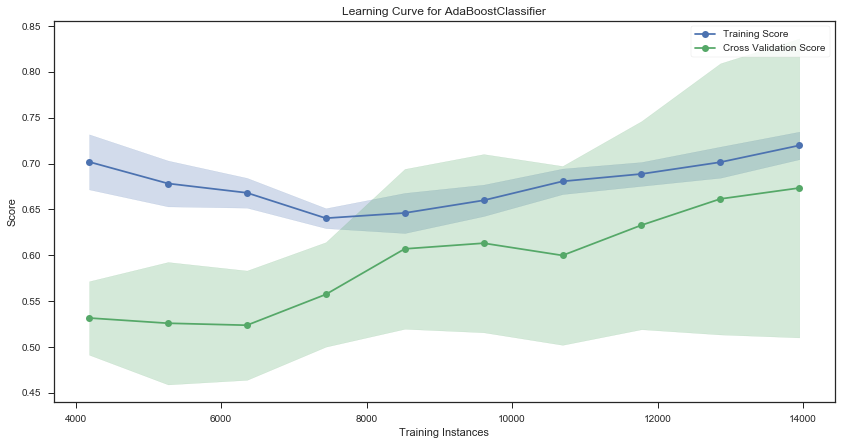

--- 66.58219909667969 seconds ---


In [191]:
def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        model)
    # Create the learning curve visualizer
    cv = StratifiedKFold(12)
    
    sizes = np.linspace(0.3, 1.0, 10)
    _,ax = plt.subplots(figsize=(14,7))
    viz = LearningCurve(
        pipe_mdl, cv=cv, train_sizes=sizes,
        scoring=scoring)
    # Fit and poof the visualizer
    viz.fit(X_resampled, Y_resampled)
    viz.poof()
    
    
for name, model in models:
    start_time = time.time()
    vizerror(name, model)
    print('--- %s seconds ---' % (time.time() - start_time))

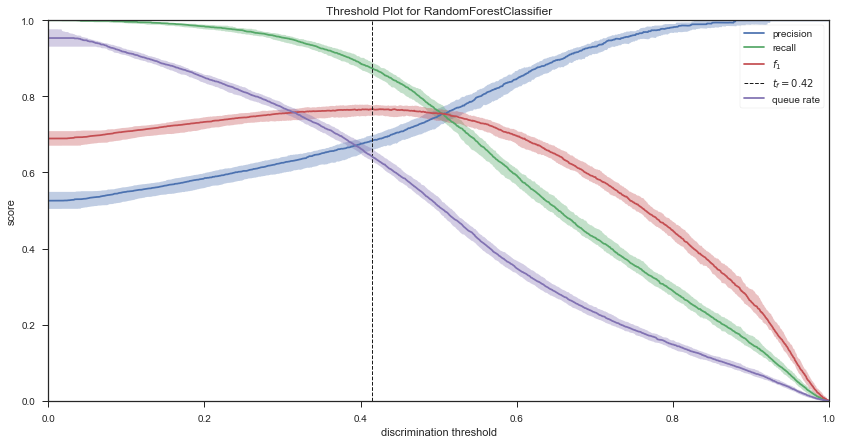

--- 110.79280090332031 seconds ---


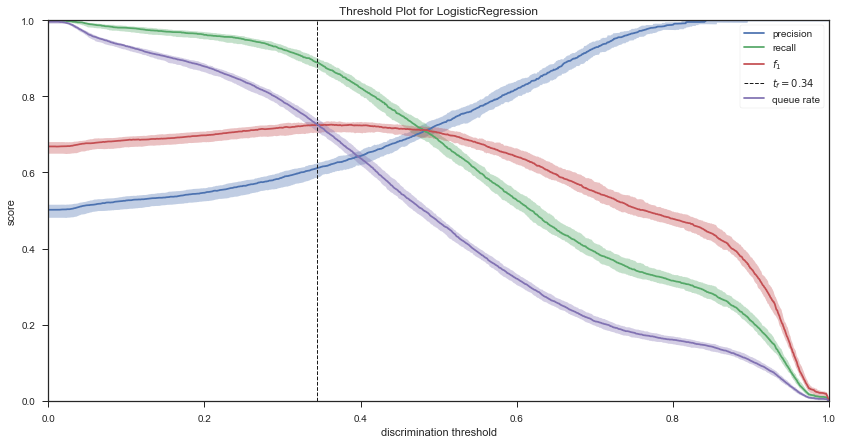

--- 20.604514122009277 seconds ---


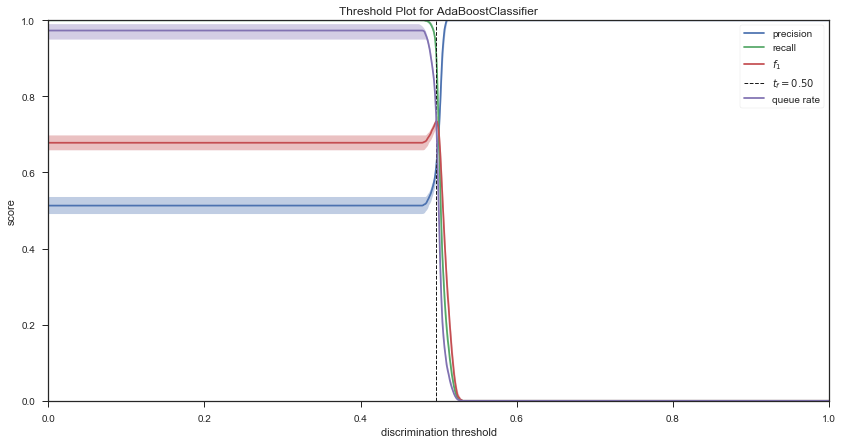

--- 39.979631662368774 seconds ---


In [192]:
def vizerror(name, model):
    pipe_mdl = make_pipeline(QuantileTransformer(),
                        model)
    _,ax = plt.subplots(figsize=(14,7))
    visualizer = DiscriminationThreshold(pipe_mdl)
    visualizer.fit(X_resampled, Y_resampled)  # Fit the training data to the visualizer
    visualizer.poof() 
    
    
for name, model in models:
    start_time = time.time()
    vizerror(name, model)
    print('--- %s seconds ---' % (time.time() - start_time))

### Model Persistance (Pickle)

In [8]:
RFC = RandomForestClassifier(criterion= 'gini', max_depth= 20, n_estimators= 120)
pipe_mdl = make_pipeline(QuantileTransformer(),
                        RFC)
pipe_mdl.fit(X_train, Y_train)

complete_model = (pipe_mdl, X_train, Y_train)
filename = 'RandomForestClassifier_model.sav'
pickle.dump(complete_model, open(filename, 'wb'))



LGR = LogisticRegression(C= 1.15, class_weight= 'balanced', dual= False, fit_intercept= True, 
                           max_iter= 10000, multi_class= 'ovr', n_jobs= 2, random_state= 7, solver= 'sag', tol= 0.0001,
                           verbose= 0, warm_start= True)
pipe_mdl = make_pipeline(QuantileTransformer(),
                        LGR)
pipe_mdl.fit(X_train, Y_train)

complete_model = (pipe_mdl, X_train, Y_train)
filename = 'LogisticRegression_model.sav'
pickle.dump(complete_model, open(filename, 'wb'))


ABC = AdaBoostClassifier()
pipe_mdl = make_pipeline(QuantileTransformer(),
                        ABC)
pipe_mdl.fit(X_train, Y_train)

complete_model = (pipe_mdl, X_train, Y_train)
filename = 'AdaBoostClassifier_model.sav'
pickle.dump(complete_model, open(filename, 'wb'))